## Fast ABOD（Angle Based Outlier Detection）による外れ値検知

## 1. ABOD（Angle-Based Outlier Detection）とは

大量のデータオブジェクトのセットで異常値を検出することは、データセット内のさまざまなデータ集合の異なるメカニズムを見つけることを目指す主要なデータマイニングタスク。

すべての既存のアプローチは、完全な次元のユークリッドデータ空間における距離の評価（ある分布を仮定することによって間接的に行われることもある）に基づいています。<br>
高次元のデータでは、これらのアプローチは悪名高い "次元の呪い"のために悪化します。

ABOD（Angle-Based Outlier Detection）と呼ばれる手法では、<br>
点の**差分ベクトル間の角度の分散**を評価するいくつかの変形を導入している。

新しいアプローチの主な利点は、品質に影響を与えるパラメータ選択に依存しない。<br>
距離に基づく方法LOFとABODを比較し、高次元データで特に優れた性能を示す。

## 2. LOF のおさらい

### 2-1. Local Outlier Factor のイメージ

<img src="14_outlier/img01.png" width="250px" height="250px">

密度の低い集合(C1)と密度の高い(C2)

データ分布全体を考慮する手法では、C1を全部外れ値としてしまうことが多い。<br>
でも、C1はC1で一つのパターンを形成している。

C1とC2を正常値とつつ、o1やo2のようなデータを弾くのがLOF

<img src="14_outlier/img02.png" width="250px" height="250px">

### 2-2. 局所密度の比に着目

局所密度＝近傍k個との距離の平均の逆数<br>
kはパラメータ

Aは自分の局所密度は低いが、近傍の局所密度は高い<br>
＝外れ値

右側のデータはどれも、自分の局所密度と近傍の局所密度は同じくらい<br>
＝正常値

### 2-3. 用語定義

### 局所密度lrd (local reachability density)の定義(距離の平均の逆数)

$ lrd(A)=(\frac{1}{k} \sum_{B \in N_{k}(A)} rd_k(A,B))^{-1}$

lrd は到達可能距離 (reachability distance，rd) の平均の逆数となっている．

### 到達可能距離 rd (reachability distance)の定義

$rd_k(x, y) = max( d(x, y), kdist(y) )$

つまり，点 x と y の距離が y の k 距離よりも近い場合には y の k 距離に置き換えて到達可能距離 rd としている

### 外れ値スコアlof の定義(局所密度の比の平均)

$lof(A)=\frac{1}{k} \sum_{B \in N_{k}(A)} \frac{lrd(B)}{lrd(A)} $

### k 距離

kdist(x) は以下の条件を満たす $d(x, o)$ である．
1. 少なくとも k 個のデータ $o' \in  D \ {x}$ に対して d(x, o') ≤ d(x, o) が成立する
2. 高々k − 1 個のデータ $o' \in D \ {x}$ に対してのみ d(x, o) < d(x, o) が成立する

すなわち，簡単には k 距離近傍集合 Nk(x) は点 x から k 番目に近い点 ok までの距離<br>
$kdist(x) =dist(x, o_k)$ の範囲内にある点の集合である．

ABODは $O(n^{3})$ に対して、Fast ABODは $O(n^2+nk^2)$ なので、計算量の面で優位となります<br>
（ただし近似精度はkに依存）。

### 2−4. ざっくりまとめ LOF 

* <b>正常な点では、LOFはほぼ１、外れ値は１から外れる。</b>
* １か０ではなく、外れ度を計算
* データ全体ではなく、近傍データから計算する。

## 3. LOF データ分析サンプル

### データの生成

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Generate train data
X = 0.3 * np.random.randn(100, 2)
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
# 縦に結合
X = np.r_[X + 2, X - 2, X_outliers]

### モデル生成：LocalOutlierFactor

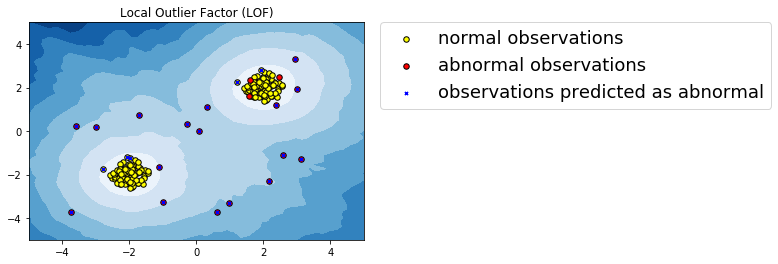

In [2]:
from sklearn.neighbors import LocalOutlierFactor

# fit the model
clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(X)
# 正常を1、異常を-1と出力するようです
ANOMALY_DATA = -1
predicted_outlier_index = np.where(y_pred == ANOMALY_DATA)
predicted_outlier = X[predicted_outlier_index]

# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Local Outlier Factor (LOF)")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

a = plt.scatter(X[:200, 0], X[:200, 1], c='yellow',
                edgecolor='k', s=30, marker='o')
b = plt.scatter(X[200:, 0], X[200:, 1], c='red',
                edgecolor='k', s=30, marker='o')
c = plt.scatter(predicted_outlier[:, 0], predicted_outlier[:, 1], c='blue',
                edgecolor='k', s=10, marker='x')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a, b, c],
           ["normal observations",
            "abnormal observations",
            "observations predicted as abnormal"],
           loc="upper left",
           bbox_to_anchor=(1.05, 1), borderaxespad=0, fontsize=18)
plt.show()

## 4. ABOD(Angle-Based Outlier Detection) 概要

### 4-1. 距離ベースの弊害

最も遠い点と最も近い点との相対的なコントラストが、次元が増加するにつれて0に収束することを示している。<br>
↓<br>
**高次元空間において**、最も近いものと最も遠いものとの間の区別がかなり貧弱になることを意味する。

大域的なノイズが存在せず、特定の特徴量のみノイズが含まれる場合、異常値と判定するのが不適切となる。<br>
↓<br>
オブジェクト間の単なる距離に依存しない手法が必要になる。<br>
↓<br>
データオブジェクトの差分ベクトル間の角度の分散を検討する。<br>
この尺度は、距離ベースの基準よりもデータセットの次元の増加に対して敏感ではない。

従来手法では<br>
* 単変量であり、単一の属性を調べて外れ値を決定している。<br>
* 場合によっては、データは複数のガウス分布から構成され、平均値と標準偏差が決定する。<br>
↓<br>
これらの方法は、平均および標準偏差が外れ値に対してかなり敏感であり、実際には堅牢ではない。



### 4-2. ABOF(the angle-based outlier factor)の数学的定義

<img src="14_outlier/img03.png" width="450px" height="450px">

[3]Angle-Based Outlier Detection in High-dimensional Data
より

<img src="14_outlier/img04.png" width="450px" height="450px">

ある点に対する観測された角度のスペクトルが広い場合、(上図ではα、βの場合)<br>
その点は可能なすべての方向で他の点に囲まれ、その点がクラスタ内に位置することを意味する。

ある点の観測された角度のスペクトルがかなり小さい場合、(上図ではγの場合)<br>
他の点は特定の方向にのみ配置されます。<br>
つまり、ポイントは、グループ化されたポイントのセットの外側に配置されます。<br>

このように、点に対する方位角は、お互いにかなり類似しているので、外れ値であることを意味する。

角度のスペクトル
<img src="14_outlier/img05.png" width="450px" height="450px">

クラスタ内部の点(inner point)は大きくなり、クラスタの境界付近(border point)は小さく、
クラスタから離れた外れ値(outlier)はさらに小さくなる。

### 4-3. Fast ABOD　の数学的定義

<img src="14_outlier/img06.png" width="450px" height="450px">

Fast ABODは k最近傍との角度を求める。

ABODは $O(n^3)$ に対して、Fast ABODは $O(n^2+nk^2)$ なので、計算量の面で優位。

<img src="14_outlier/img07.png" width="450px" height="450px">

## 5. FastABOD データ分析サンプル

### モデル生成：FastABOD

In [3]:
import numpy as np
import itertools
from sklearn.neighbors import NearestNeighbors

class FastABOD:
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors

    def fit_predict(self, X, contamination=0.1):
        # 各点のk最近傍を求める
        k_nearest = NearestNeighbors(n_neighbors=self.n_neighbors).fit(X)
        distances, indices = k_nearest.kneighbors(X)
        
        # k最近傍との角度を求めるための組み合わせ計算
        numbers = [i + 1 for i in range(distances.shape[1] - 1)]
        combs = list(itertools.combinations(numbers, 2))
        
        # ABOFを求める
        abofs = []
        for i in range(len(X)):
            x = X[indices[i]]
            abof = self._compute_abof(x, combs)
            abofs.append(abof)
        
        # ABOFスコア下位N%を異常と見なす
        ordered_abofs = np.argsort(abofs)
        anomaly_indices = ordered_abofs[:int(len(abofs)*contamination + 0.5)]
        
        # scikit-learnに倣って正常を1、異常を-1として返す
        prediction = np.ones((len(abofs)), dtype=np.int)
        prediction[anomaly_indices] = -1
        return prediction

    def _compute_abof(self, x, combs):
        numerator1 = 0
        numerator2 = 0
        denominator1 = 0
        for comb in combs:
            AB = x[comb[0]] - x[0]
            AC = x[comb[1]] - x[0]
            AB_norm = np.linalg.norm(AB)
            AC_norm = np.linalg.norm(AC)
            a = 1 / (AB_norm * AC_norm)
            b = np.dot(AB, AC) / ((AB_norm ** 2) * (AC_norm ** 2))
            numerator1 += a * (b ** 2)
            denominator1 += a
            numerator2 += a * b
        denominator2 = denominator1
        return numerator1 / denominator1 - (numerator2 / denominator2) ** 2

次にFastABODクラスを利用して外れ値検出を行う例です。

（ただし、ABOD自体は**高次元データにも精度良く適用できる**手法というのが特徴なので、<br>
以下のように二次元データに適用するのは例としては良くない）

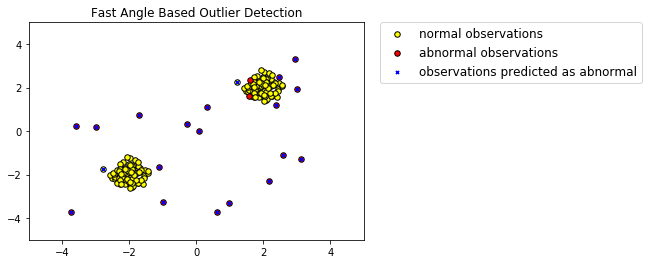

In [4]:
# fit the model
classifier = FastABOD(n_neighbors=10)
# 全体の9%が異常データ
contamination = 0.09

y_pred = classifier.fit_predict(X, contamination)
# 正常を1、異常を-1と出力します
ANOMALY_DATA = -1
predicted_outlier_index = np.where(y_pred == ANOMALY_DATA)
predicted_outlier = X[predicted_outlier_index]

# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
#Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
#Z = Z.reshape(xx.shape)

plt.title("Fast Angle Based Outlier Detection")
#plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

a = plt.scatter(X[:200, 0], X[:200, 1], c='yellow',
                edgecolor='k', s=30, marker='o')
b = plt.scatter(X[200:, 0], X[200:, 1], c='red',
                edgecolor='k', s=30, marker='o')
c = plt.scatter(predicted_outlier[:, 0], predicted_outlier[:, 1], c='blue',
                edgecolor='k', s=10, marker='x')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a, b, c],
           ["normal observations",
            "abnormal observations",
            "observations predicted as abnormal"],
           loc="upper left", prop={'size': 12},
           bbox_to_anchor=(1.05, 1), borderaxespad=0, fontsize=18)
plt.show()

## 参考文献

[1]LOF: Identifying Density-Based Local Outliers<br>
http://www.dbs.ifi.lmu.de/Publikationen/Papers/LOF.pdf

[2]外れ値検出手法を利用した Misleading データの検出<br>
https://www.ninjal.ac.jp/event/specialists/project-meeting/files/JCLWorkshop_no5_papers/JCLWorkshop_No5_06.pdf

[3]Angle-Based Outlier Detection in High-dimensional Data<br>
http://www.dbs.ifi.lmu.de/Publikationen/Papers/KDD2008.pdf